heights.shape=(130, 130)
z_min=2432.869873046875, z_max=3567.31494140625
normals.shape=(128, 128, 3)
heights.shape=(128, 128)


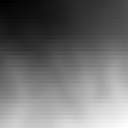

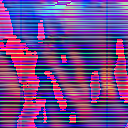

In [5]:
# trying to compute normal map and bump map
# from heights retrieved using https://data.geopf.fr/wms-r/wms
#
import requests
import numpy as np
from PIL import Image

N=128

# query WMS with 2 extra pixel
bbox=[766813.8789930125,5761515.054564301,768041.6487596722,5762742.824330961]
bboxString=','.join([str(i) for i in bbox])
#layerName="ELEVATION.ELEVATIONGRIDCOVERAGE"
layerName="ELEVATION.ELEVATIONGRIDCOVERAGE.HIGHRES"
url=f"https://data.geopf.fr/wms-r/wms?request=GetMap&service=WMS&version=1.3.0&bbox={bboxString}&layers={layerName}&format=image/x-bil;bits=32&WIDTH={N+2}&HEIGHT={N+2}&CRS=EPSG:3857&STYLES=&INTERPOLATIONS=bicubic"
response = requests.get(url)
response.raise_for_status()

# convert response to numpy array
data=response.content
heights=np.frombuffer(data, dtype=np.float32).reshape((N+2,N+2))
print(f'heights.shape={heights.shape}')
#print(f'heights={heights}')

# compute stats to renders heights
z_min=np.min(heights)
z_max=np.max(heights)
print(f'z_min={z_min}, z_max={z_max}')

normals=np.zeros((N,N,3), dtype=np.uint8)
dx=(bbox[2]-bbox[0])/N
dy=(bbox[3]-bbox[1])/N
print(f'normals.shape={normals.shape}')
for iy in range(0,N):
    for ix in range(0,N):
        # TODO check
        dzx = heights[iy+1][ix+2] - heights[iy+1][ix]
        dzy = heights[iy+2][ix+1] - heights[iy][ix+1]
        normal = np.array([
            2.0*dy*dzx,
            -2.0*dx*dzy,
            2.0*dx*dy
        ])
        normal = normal / np.sqrt(np.sum(normal**2))
        normals[iy][ix] =  np.uint8(normal*256.0)

# remove extra pixels
heights=heights[1:N+1,1:N+1]
print(f'heights.shape={heights.shape}')

# convert heights to image
img_heights = Image.fromarray(np.uint8(256.0 * ( heights - z_min ) / ( z_max - z_min)), 'L')
display(img_heights)
img_heights.save('wms-heights.png')

# convert normals to image
img_normals = Image.fromarray(normals, 'RGB')
display(img_normals)
img_normals.save('wms-normals.png')


